In [1]:
# Force CPU usage to avoid GPU memory issues
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [2]:
# Import ToxiCR
from ToxiCR import ToxiCR


In [3]:
# Initialize the ToxiCR model with pretrained weights
print("Loading pretrained ToxiCR model...")

toxicClassifier = ToxiCR(
    ALGO="BERT",
    count_profanity=False,
    remove_keywords=True,
    split_identifier=False,
    embedding="bert",
    load_pretrained=True
)

# Load the model
result = toxicClassifier.init_predictor()

if result:
    print("Pretrained model loaded successfully!")
else:
    print("Failed to load pretrained model")
    raise Exception("Model loading failed")


Loading pretrained ToxiCR model...
getPTMName  /home/strrl/Project/toxiCR/pre-trained/model-BERT-bert-profane-False-keyword-True-split-False.h5


2025-08-04 21:47:14.044621: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-08-04 21:47:20.835239: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-08-04 21:47:20.878842: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-04 21:47:20.878924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: goom
2025-08-04 21:47:20.878935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: goom
2025-08-04 21:47:20.891132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 550.144.3
2025-08-04 21:47:20.891184: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.144.3
2025-08-04 21:47:20.891192: I tensorflow/stream_executor/

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


2025-08-04 21:47:21.772043: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 21:47:22.409201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-08-04 21:47:22.420374: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2112000000 Hz


Attempting to load model from: /home/strrl/Project/toxiCR/pre-trained/model-BERT-bert-profane-False-keyword-True-split-False.h5
Model loaded and recompiled successfully
Successfully loaded pretrained model from /home/strrl/Project/toxiCR/pre-trained/model-BERT-bert-profane-False-keyword-True-split-False.h5
Pretrained model loaded successfully!


In [4]:
# Load the dataset

data = pd.read_excel("models/code-review-dataset-full.xlsx")

In [ ]:
# Explore target distribution
print("Target Distribution:")
target_counts = data['is_toxic'].value_counts()
print(target_counts)
print(f"\nToxic ratio: {target_counts[1] / len(data):.2%}")
print(f"Non-toxic ratio: {target_counts[0] / len(data):.2%}")


Target Distribution:
0    15894
1     3757
Name: is_toxic, dtype: int64

Toxic ratio: 19.12%
Non-toxic ratio: 80.88%


In [7]:
print("Making predictions on the full dataset...")

messages = data['message'].tolist()
true_labels = data['is_toxic'].values

probabilities = toxicClassifier.get_toxicity_probability(messages)
probabilities = np.array(probabilities)

predictions = (probabilities >= 0.5).astype(int)

print(f"Predictions completed!")
print(f"Shape: {probabilities.shape}")
print(f"Min probability: {probabilities.min():.4f}")
print(f"Max probability: {probabilities.max():.4f}")
print(f"Mean probability: {probabilities.mean():.4f}")


Making predictions on the full dataset...
















































































100%|██████████| 77/77 [16:09<00:00, 12.59s/it]
0it [16:09, ?it/s]

Predictions completed!
Shape: (19651,)
Min probability: 0.0014
Max probability: 0.9978
Mean probability: 0.1980


In [8]:
# Calculate comprehensive metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Calculate metrics for both classes
precision_macro = precision_score(true_labels, predictions, average='macro')
recall_macro = recall_score(true_labels, predictions, average='macro')
f1_macro = f1_score(true_labels, predictions, average='macro')


In [9]:
# Generate detailed classification report
print("DETAILED CLASSIFICATION REPORT")
print("=" * 50)
report = classification_report(true_labels, predictions, 
                             target_names=['Non-Toxic', 'Toxic'],
                             digits=4)
print(report)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Toxic     0.9852    0.9789    0.9821     15894
       Toxic     0.9132    0.9380    0.9254      3757

    accuracy                         0.9711     19651
   macro avg     0.9492    0.9585    0.9537     19651
weighted avg     0.9715    0.9711    0.9712     19651



ROC AUC Score: 0.9899
PR AUC Score: 0.9731


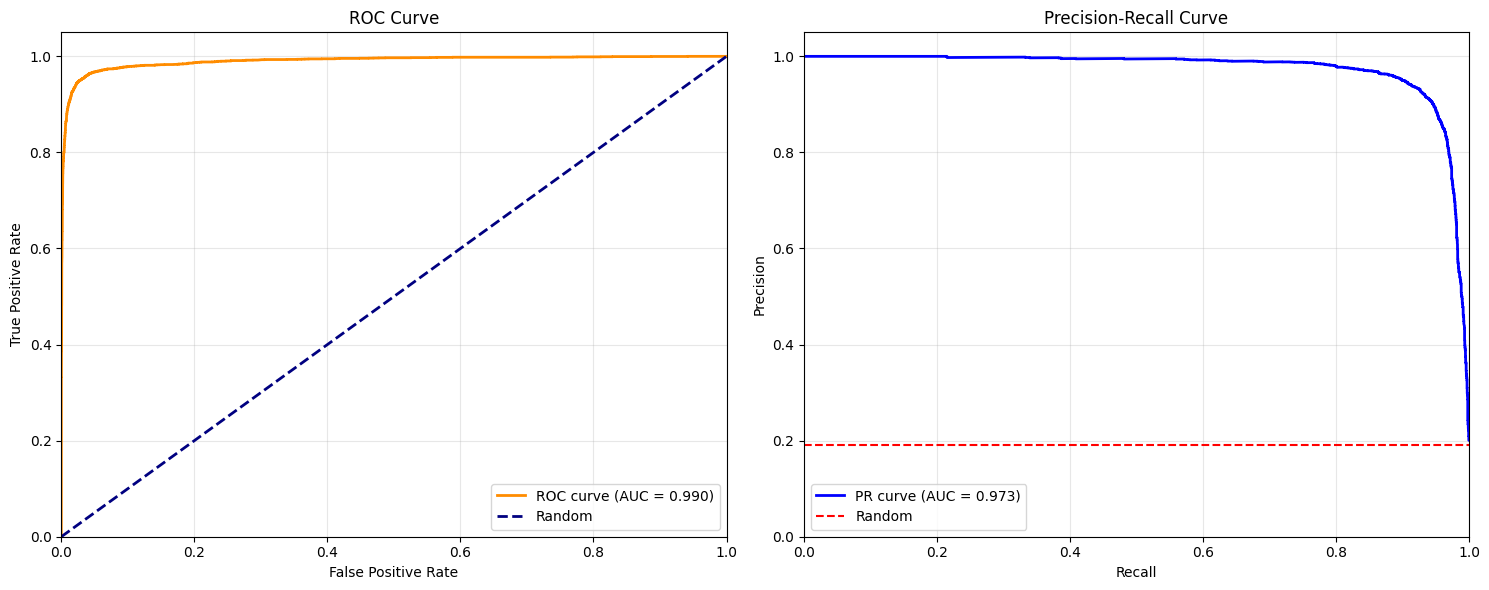

In [10]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(true_labels, probabilities)
pr_auc = auc(recall_curve, precision_curve)

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# Plot ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
ax2.axhline(y=true_labels.mean(), color='red', linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()
